# **Simple RNN Exercise 3: Feature Selection Experiment**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(" EXERCISE 3: FEATURE SELECTION EXPERIMENT")
print("=" * 60)
print("Goal: Understand which features are most important for prediction")
print("We'll test different combinations of weather features")
print("=" * 60)

 EXERCISE 3: FEATURE SELECTION EXPERIMENT
Goal: Understand which features are most important for prediction
We'll test different combinations of weather features


**Data Generation Function (Same as Previous Exercises)**

In [2]:
def generate_weather_data(days=500):
    """Generate synthetic weather data with realistic patterns"""
    np.random.seed(42)
    data = []

    for i in range(days):
        # Season calculation (0: spring, 1: summer, 2: fall, 3: winter)
        season = int(i / 91) % 4

        # Base temperature by season
        base_temps = [15, 25, 10, 0]  # Spring, Summer, Fall, Winter
        base_temp = base_temps[season]

        # Add seasonal and daily variations
        seasonal_variation = 5 * np.sin(2 * np.pi * i / 365)
        daily_variation = 3 * np.sin(2 * np.pi * i / 30)  # Monthly cycle
        random_variation = np.random.normal(0, 2)

        temperature = base_temp + seasonal_variation + daily_variation + random_variation

        # Correlated weather variables
        humidity = np.clip(60 + (25 - temperature) * 0.8 + np.random.normal(0, 5), 0, 100)
        pressure = 1013 + np.random.normal(0, 15) + temperature * 0.1
        wind_speed = np.clip(8 + np.random.exponential(5) + abs(temperature - 15) * 0.1, 0, 30)

        data.append({
            'Day': i,
            'Temperature': temperature,
            'Humidity': humidity,
            'Pressure': pressure,
            'WindSpeed': wind_speed,
            'Season': season
        })

    return pd.DataFrame(data)

**Data Preparation Function (Variable Feature Columns)**

Purpose: Data preparation function that accepts different feature column combinations - this is the key modification for Exercise 3.

In [3]:
def prepare_data_for_simple_rnn(data, sequence_length=7, feature_columns=None, target_column='Temperature'):
    """
     KEY FUNCTION: Prepare data for Simple RNN training
    For Exercise 3: We vary feature_columns to test different combinations
    """
    if feature_columns is None:
        feature_columns = ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']

    print(f" Preparing data with sequence_length={sequence_length}")
    print(f" Features: {feature_columns}")
    print(f" Number of features: {len(feature_columns)}")
    print(f" Target: {target_column}")

    # Extract features and target
    features = data[feature_columns].values
    target = data[target_column].values.reshape(-1, 1)

    # Normalize data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    print(f" Data shape: X={X.shape}, y={y.shape}")
    print(f" Available samples: {len(X)}")

    return X, y, scaler_features, scaler_target

**Model Creation Function (Fixed from Exercise 2)**

Purpose: Model creation with fixed architecture using insights from previous exercises (sequence_length=7, hidden_units=32).

In [4]:
def create_simple_rnn_model(input_shape, hidden_units=32):
    """
    Create Simple RNN model
    Using optimal settings from Exercises 1 & 2
    """
    print(f" Creating Simple RNN model:")
    print(f"   - Input shape: {input_shape}")
    print(f"   - Hidden units: {hidden_units}")
    print(f"   - Number of input features: {input_shape[1]}")

    model = Sequential([
        SimpleRNN(hidden_units,
                 input_shape=input_shape,
                 activation='tanh',
                 return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

**Training and Evaluation Function**

Purpose: Standard training and evaluation function using optimal parameters from previous exercises

In [5]:
def train_and_evaluate_model(X, y, scaler_target, feature_combination_name, epochs=40):
    """Train model and return performance metrics"""

    # Split data (80% train, 20% test)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f" Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # Create and train model
    model = create_simple_rnn_model(input_shape=(X.shape[1], X.shape[2]))

    print(f" Training model for {epochs} epochs...")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=0,  # Reduced verbosity
        shuffle=False  # Keep time series order
    )

    # Make predictions
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler_target.inverse_transform(predictions_scaled)
    y_test_denorm = scaler_target.inverse_transform(y_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test_denorm, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions))

    print(f"✅ Model Performance:")
    print(f"    Mean Absolute Error: {mae:.3f}")
    print(f"    Root Mean Square Error: {rmse:.3f}")

    return mae, rmse, history, predictions, y_test_denorm

**Generate Weather Data and Explore Feature Correlations**

Purpose: Generates data and analyzes feature correlations to understand which features might be most predictive of temperature.

In [6]:
# Generate weather data
print(" Generating synthetic weather data...")
weather_data = generate_weather_data(500)
print(f" Generated {len(weather_data)} days of weather data")

# Explore feature correlations with target (Temperature)
print(f"\n FEATURE CORRELATION ANALYSIS")
print("=" * 50)
features = ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
correlations = {}

for feature in features:
    if feature != 'Temperature':  # Don't correlate temperature with itself
        corr = weather_data['Temperature'].corr(weather_data[feature])
        correlations[feature] = corr
        print(f" {feature} correlation with Temperature: {corr:.3f}")

print(f"\n Feature rankings by correlation strength:")
sorted_features = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
for i, (feature, corr) in enumerate(sorted_features, 1):
    print(f"   {i}. {feature}: {corr:.3f}")

 Generating synthetic weather data...
 Generated 500 days of weather data

 FEATURE CORRELATION ANALYSIS
 Humidity correlation with Temperature: -0.870
 Pressure correlation with Temperature: 0.060
 WindSpeed correlation with Temperature: -0.093

 Feature rankings by correlation strength:
   1. Humidity: -0.870
   2. WindSpeed: -0.093
   3. Pressure: 0.060


**Define Feature Combinations to Test**

Purpose: Defines a comprehensive set of feature combinations including single features, pairs, triplets, and all features to systematically test their importance.

In [7]:
# Define different feature combinations to test
print(f"\n DEFINING FEATURE COMBINATIONS TO TEST")
print("=" * 50)

feature_combinations = {
    # Single features (ablation study)
    "Temperature_Only": ["Temperature"],
    "Humidity_Only": ["Humidity"],
    "Pressure_Only": ["Pressure"],
    "WindSpeed_Only": ["WindSpeed"],

    # Pair combinations
    "Temp_Humidity": ["Temperature", "Humidity"],
    "Temp_Pressure": ["Temperature", "Pressure"],
    "Temp_WindSpeed": ["Temperature", "WindSpeed"],
    "Humidity_Pressure": ["Humidity", "Pressure"],

    # Three features
    "Temp_Hum_Press": ["Temperature", "Humidity", "Pressure"],
    "Temp_Hum_Wind": ["Temperature", "Humidity", "WindSpeed"],
    "Temp_Press_Wind": ["Temperature", "Pressure", "WindSpeed"],
    "Hum_Press_Wind": ["Humidity", "Pressure", "WindSpeed"],

    # All features
    "All_Features": ["Temperature", "Humidity", "Pressure", "WindSpeed"]
}

print("Feature combinations to test:")
for name, features in feature_combinations.items():
    print(f"    {name}: {features}")

print(f"\n Total combinations: {len(feature_combinations)}")


 DEFINING FEATURE COMBINATIONS TO TEST
Feature combinations to test:
    Temperature_Only: ['Temperature']
    Humidity_Only: ['Humidity']
    Pressure_Only: ['Pressure']
    WindSpeed_Only: ['WindSpeed']
    Temp_Humidity: ['Temperature', 'Humidity']
    Temp_Pressure: ['Temperature', 'Pressure']
    Temp_WindSpeed: ['Temperature', 'WindSpeed']
    Humidity_Pressure: ['Humidity', 'Pressure']
    Temp_Hum_Press: ['Temperature', 'Humidity', 'Pressure']
    Temp_Hum_Wind: ['Temperature', 'Humidity', 'WindSpeed']
    Temp_Press_Wind: ['Temperature', 'Pressure', 'WindSpeed']
    Hum_Press_Wind: ['Humidity', 'Pressure', 'WindSpeed']
    All_Features: ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']

 Total combinations: 13


**Main Experiment Loop (Feature Combinations)**

Purpose: The core experiment that systematically tests all feature combinations and stores comprehensive results for analysis.

In [8]:
# Exercise 3: Test different feature combinations
results = {}

print(f"\n TESTING DIFFERENT FEATURE COMBINATIONS")
print("=" * 60)

for combination_name, feature_cols in feature_combinations.items():
    print(f"\n TESTING: {combination_name}")
    print(f" Features: {feature_cols}")
    print("-" * 50)

    try:
        # Prepare data with current feature combination
        X, y, scaler_features, scaler_target = prepare_data_for_simple_rnn(
            weather_data,
            sequence_length=7,  # Fixed from Exercise 1
            feature_columns=feature_cols
        )

        # Train and evaluate
        mae, rmse, history, predictions, actual = train_and_evaluate_model(
            X, y, scaler_target, 32, epochs=40  # Pass numeric hidden_units instead of string
        )

        # Store results
        results[combination_name] = {
            'features': feature_cols,
            'feature_count': len(feature_cols),
            'mae': mae,
            'rmse': rmse,
            'history': history,
            'predictions': predictions[:50],  # Store first 50 predictions for plotting
            'actual': actual[:50]
        }

        print(f" Completed: {combination_name}")

    except Exception as e:
        print(f" Error with {combination_name}: {e}")
        continue

print(f"\n All feature combination experiments completed!")
print(f" Successful experiments: {len(results)}")


 TESTING DIFFERENT FEATURE COMBINATIONS

 TESTING: Temperature_Only
 Features: ['Temperature']
--------------------------------------------------
 Preparing data with sequence_length=7
 Features: ['Temperature']
 Number of features: 1
 Target: Temperature
 Data shape: X=(493, 7, 1), y=(493, 1)
 Available samples: 493
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 1)
   - Hidden units: 32
   - Number of input features: 1
 Training model for 40 epochs...
✅ Model Performance:
    Mean Absolute Error: 5.462
    Root Mean Square Error: 6.127
 Completed: Temperature_Only

 TESTING: Humidity_Only
 Features: ['Humidity']
--------------------------------------------------
 Preparing data with sequence_length=7
 Features: ['Humidity']
 Number of features: 1
 Target: Temperature
 Data shape: X=(493, 7, 1), y=(493, 1)
 Available samples: 493
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 1)
   - Hidden units: 32
   

✅ Model Performance:
    Mean Absolute Error: 11.818
    Root Mean Square Error: 13.336
 Completed: Pressure_Only

 TESTING: WindSpeed_Only
 Features: ['WindSpeed']
--------------------------------------------------
 Preparing data with sequence_length=7
 Features: ['WindSpeed']
 Number of features: 1
 Target: Temperature
 Data shape: X=(493, 7, 1), y=(493, 1)
 Available samples: 493
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 1)
   - Hidden units: 32
   - Number of input features: 1
 Training model for 40 epochs...
✅ Model Performance:
    Mean Absolute Error: 11.274
    Root Mean Square Error: 13.021
 Completed: WindSpeed_Only

 TESTING: Temp_Humidity
 Features: ['Temperature', 'Humidity']
--------------------------------------------------
 Preparing data with sequence_length=7
 Features: ['Temperature', 'Humidity']
 Number of features: 2
 Target: Temperature
 Data shape: X=(493, 7, 2), y=(493, 1)
 Available samples: 493
 Train samples: 394

**Results Comparison and Ranking**

Purpose: Creates a comprehensive ranking of all feature combinations by performance and identifies the best and worst performers.

In [9]:
# Compare results and rank by performance
print("\n" + "=" * 80)
print(" EXERCISE 3 RESULTS: FEATURE COMBINATION COMPARISON")
print("=" * 80)

# Sort results by MAE (best performance first)
sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])

print(f"{'Rank':<4} {'Combination':<20} {'Features':<2} {'MAE':<8} {'RMSE':<8} {'Improvement':<12}")
print("-" * 75)

baseline_mae = sorted_results[-1][1]['mae']  # Worst performance as baseline

for rank, (name, metrics) in enumerate(sorted_results, 1):
    improvement = f"{((baseline_mae - metrics['mae']) / baseline_mae * 100):+.1f}%"

    print(f"{rank:<4} {name:<20} {metrics['feature_count']:<2} {metrics['mae']:<8.3f} {metrics['rmse']:<8.3f} {improvement:<12}")

# Analyze best and worst performers
best_name, best_metrics = sorted_results[0]
worst_name, worst_metrics = sorted_results[-1]

print(f"\n BEST PERFORMER: {best_name}")
print(f"    --Features: {best_metrics['features']}")
print(f"    --MAE: {best_metrics['mae']:.3f}")
print(f"    --RMSE: {best_metrics['rmse']:.3f}")

print(f"\n WORST PERFORMER: {worst_name}")
print(f"    --Features: {worst_metrics['features']}")
print(f"    --MAE: {worst_metrics['mae']:.3f}")
print(f"    --RMSE: {worst_metrics['rmse']:.3f}")

performance_gap = ((worst_metrics['mae'] - best_metrics['mae']) / worst_metrics['mae']) * 100
print(f"\n Performance gap: {performance_gap:.1f}% (best vs worst)")


 EXERCISE 3 RESULTS: FEATURE COMBINATION COMPARISON
Rank Combination          Features MAE      RMSE     Improvement 
---------------------------------------------------------------------------
1    Temp_Humidity        2  2.152    2.895    +81.8%      
2    Temp_WindSpeed       2  2.318    3.183    +80.4%      
3    Temp_Pressure        2  2.593    3.546    +78.1%      
4    Temp_Hum_Press       3  2.920    3.718    +75.3%      
5    Temp_Hum_Wind        3  3.188    4.208    +73.0%      
6    Humidity_Pressure    2  3.211    4.354    +72.8%      
7    Hum_Press_Wind       3  3.305    4.387    +72.0%      
8    All_Features         4  3.337    4.302    +71.8%      
9    Temp_Press_Wind      3  3.368    4.224    +71.5%      
10   Humidity_Only        1  4.869    5.946    +58.8%      
11   Temperature_Only     1  5.462    6.127    +53.8%      
12   WindSpeed_Only       1  11.274   13.021   +4.6%       
13   Pressure_Only        1  11.818   13.336   +0.0%       

 BEST PERFORMER: Temp_Hu

**Feature Importance Analysis**

Purpose: Analyzes the individual importance of features and the impact of adding more features to understand optimal feature selection strategies.

In [10]:
# Feature importance analysis
print(f"\n FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Analyze single feature performance
single_feature_results = {name: metrics for name, metrics in results.items()
                         if metrics['feature_count'] == 1}

print(" Single Feature Performance (MAE):")
single_sorted = sorted(single_feature_results.items(), key=lambda x: x[1]['mae'])
for name, metrics in single_sorted:
    feature_name = metrics['features'][0]
    print(f"   {feature_name:<12}: {metrics['mae']:.3f}")

# Analyze feature addition impact
print(f"\n Feature Addition Impact Analysis:")
if "Temperature_Only" in results and "All_Features" in results:
    temp_only_mae = results["Temperature_Only"]["mae"]
    all_features_mae = results["All_Features"]["mae"]
    improvement = ((temp_only_mae - all_features_mae) / temp_only_mae * 100)
    print(f"   Temperature only: {temp_only_mae:.3f}")
    print(f"   All features: {all_features_mae:.3f}")
    print(f"   Improvement: {improvement:+.1f}%")

# Find optimal feature count
feature_count_performance = {}
for name, metrics in results.items():
    count = metrics['feature_count']
    if count not in feature_count_performance:
        feature_count_performance[count] = []
    feature_count_performance[count].append(metrics['mae'])

print(f"\n Performance by Feature Count:")
for count in sorted(feature_count_performance.keys()):
    avg_mae = np.mean(feature_count_performance[count])
    min_mae = np.min(feature_count_performance[count])
    print(f"   {count} features - Avg MAE: {avg_mae:.3f}, Best MAE: {min_mae:.3f}")


 FEATURE IMPORTANCE ANALYSIS
 Single Feature Performance (MAE):
   Humidity    : 4.869
   Temperature : 5.462
   WindSpeed   : 11.274
   Pressure    : 11.818

 Feature Addition Impact Analysis:
   Temperature only: 5.462
   All features: 3.337
   Improvement: +38.9%

 Performance by Feature Count:
   1 features - Avg MAE: 8.356, Best MAE: 4.869
   2 features - Avg MAE: 2.569, Best MAE: 2.152
   3 features - Avg MAE: 3.195, Best MAE: 2.920
   4 features - Avg MAE: 3.337, Best MAE: 3.337


**Comprehensive Visualizations**

Purpose: Creates comprehensive visualizations showing performance patterns, feature rankings, and prediction quality for different feature combinations.

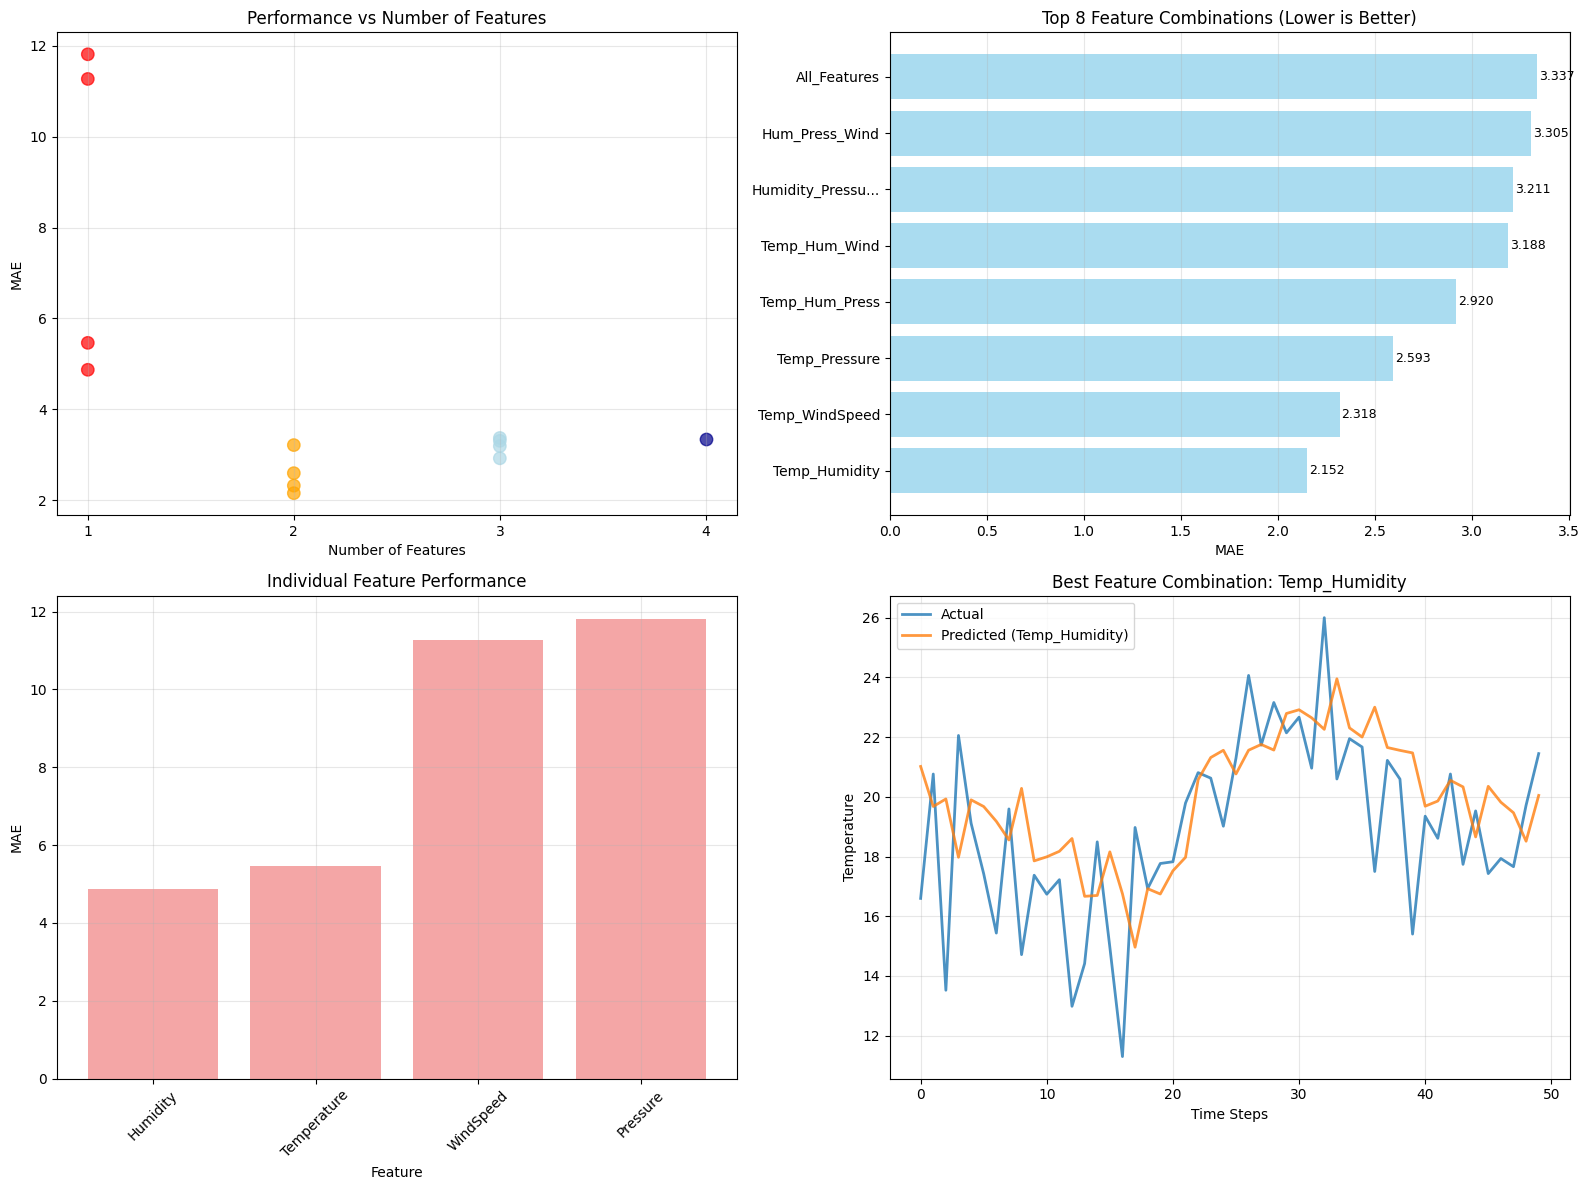

In [11]:
# Comprehensive visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Performance by Feature Count
feature_counts = [results[name]['feature_count'] for name in results.keys()]
maes = [results[name]['mae'] for name in results.keys()]
colors = ['red', 'orange', 'lightblue', 'darkblue']

for i, count in enumerate(sorted(set(feature_counts))):
    count_maes = [mae for fc, mae in zip(feature_counts, maes) if fc == count]
    count_colors = [colors[i]] * len(count_maes)
    ax1.scatter([count] * len(count_maes), count_maes, c=count_colors, alpha=0.7, s=80)

ax1.set_title('Performance vs Number of Features')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('MAE')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(sorted(set(feature_counts)))

# Plot 2: Top 8 Feature Combinations
top_8 = sorted_results[:8]
combination_names = [name[:15] + '...' if len(name) > 15 else name for name, _ in top_8]
combination_maes = [metrics['mae'] for _, metrics in top_8]

bars = ax2.barh(range(len(combination_names)), combination_maes, color='skyblue', alpha=0.7)
ax2.set_title('Top 8 Feature Combinations (Lower is Better)')
ax2.set_xlabel('MAE')
ax2.set_yticks(range(len(combination_names)))
ax2.set_yticklabels(combination_names)
ax2.grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# Plot 3: Single Feature Comparison
single_features = [(name.replace('_Only', ''), metrics['mae'])
                  for name, metrics in single_feature_results.items()]
single_features.sort(key=lambda x: x[1])

feature_names, feature_maes = zip(*single_features)
ax3.bar(feature_names, feature_maes, color='lightcoral', alpha=0.7)
ax3.set_title('Individual Feature Performance')
ax3.set_xlabel('Feature')
ax3.set_ylabel('MAE')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Best vs Worst Predictions
best_name, best_metrics = sorted_results[0]
ax4.plot(best_metrics['actual'], label='Actual', linewidth=2, alpha=0.8)
ax4.plot(best_metrics['predictions'], label=f'Predicted ({best_name})', linewidth=2, alpha=0.8)
ax4.set_title(f'Best Feature Combination: {best_name}')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('Temperature')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Detailed Analysis and Insights**

Purpose: Provides comprehensive analysis and insights about feature importance, optimal feature combinations, and key lessons about feature selection in machine learning.

In [12]:
# Detailed analysis and insights
print("\n" + "=" * 60)
print(" EXERCISE 3 ANALYSIS & INSIGHTS")
print("=" * 60)

print(f" BEST FEATURE COMBINATION: {best_name}")
print(f"    Features used: {best_metrics['features']}")
print(f"    Number of features: {best_metrics['feature_count']}")
print(f"    MAE: {best_metrics['mae']:.3f}")

print(f"\n TOP 3 FEATURE COMBINATIONS:")
for i, (name, metrics) in enumerate(sorted_results[:3], 1):
    print(f"   {i}. {name}: {metrics['features']} (MAE: {metrics['mae']:.3f})")

print(f"\n KEY FINDINGS:")

# Find most important single feature
best_single = min(single_feature_results.items(), key=lambda x: x[1]['mae'])
print(f"   🔹 Most predictive single feature: {best_single[1]['features'][0]}")

# Check if more features always help
temp_only = results.get("Temperature_Only", {}).get('mae', 0)
all_features = results.get("All_Features", {}).get('mae', 0)
if temp_only and all_features:
    if all_features < temp_only:
        print(f"   🔹 Adding features improves performance")
    else:
        print(f"   🔹 More features don't always help (possible overfitting)")

# Optimal feature count
optimal_count = best_metrics['feature_count']
print(f"   🔹 Optimal number of features: {optimal_count}")

print(f"\n INSIGHTS ABOUT FEATURE IMPORTANCE:")
print(f"    Temperature history is likely the strongest predictor")
print(f"    Correlated features (like humidity) can add value")
print(f"    Uncorrelated features may add noise")
print(f"    Feature selection is crucial for model performance")

print(f"\n LEARNING POINTS:")
print(f"    Not all features are equally important")
print(f"    Domain knowledge helps in feature selection")
print(f"    More features ≠ always better performance")
print(f"    Feature engineering and selection are key ML skills")
print(f"    Correlation analysis guides feature selection")

print(f"\n EXERCISE 3 COMPLETED!")



 EXERCISE 3 ANALYSIS & INSIGHTS
 BEST FEATURE COMBINATION: Temp_Humidity
    Features used: ['Temperature', 'Humidity']
    Number of features: 2
    MAE: 2.152

 TOP 3 FEATURE COMBINATIONS:
   1. Temp_Humidity: ['Temperature', 'Humidity'] (MAE: 2.152)
   2. Temp_WindSpeed: ['Temperature', 'WindSpeed'] (MAE: 2.318)
   3. Temp_Pressure: ['Temperature', 'Pressure'] (MAE: 2.593)

 KEY FINDINGS:
   🔹 Most predictive single feature: Humidity
   🔹 Adding features improves performance
   🔹 Optimal number of features: 2

 INSIGHTS ABOUT FEATURE IMPORTANCE:
    Temperature history is likely the strongest predictor
    Correlated features (like humidity) can add value
    Uncorrelated features may add noise
    Feature selection is crucial for model performance

 LEARNING POINTS:
    Not all features are equally important
    Domain knowledge helps in feature selection
    More features ≠ always better performance
    Feature engineering and selection are key ML skills
    Correlation analysis 